# Introduction


The purpose of this notebook is to present the operations and analysis that have been performed in order to reach the conclusions presented in the blogpost.

The notebook is divided in the following sections:
    
   1. Loading and preparing the data - as the name says, in this section we will read the data from the dataset         files and prepare everything we need to perform the analysis.
   2. The first question we are asking ourselves is what categories of videos are more likely to be successful?         Are the answers going to be similar for all regions or are we going to encounter differences?
   3. Most successful videos have a big number of likes, dislikes and comments. However, is this always true? Can       we predict the number of views by knowing how many reactions or comments have been given on that video? Is         the popularity influenced more by likes or dislikes?
   4. What are the channels that are trending the most? How many times did a video posted by that channel reach         trending?
   5. Is the popularity of a video influenced by the date in which it was posted? How old are the videos in             trending usually?

# Loading the Data

In this section, we are going to load the data for each of the regions we are going to analyze. The dataset provides detailed information about 10 countries. Each of the countries is described by two files: a csv file that contains the actual data and a json file that contains the metadata of the columns. Below, we are going to read the data and prepare the dataset.

In [1]:
import pandas as pd
from pandas.io.json import json_normalize  
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import json
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from datetime import timedelta

%matplotlib inline


CANADA = "Canada"
GERMANY = "Germany"
FRANCE = "France"
GREAT_BRITAIN = "Great_Britain"
INDIA = "India"
JAPAN = "Japan"
SOUTH_KOREA = "South_Korea"
MEXICO = "Mexico"
RUSSIA = "Mexico"
USA = "USA"

canada_dataset = pd.read_csv('data/CAvideos.csv')
germany_dataset = pd.read_csv('data/DEvideos.csv')
france_dataset = pd.read_csv('data/FRvideos.csv')
great_britain_dataset = pd.read_csv('data/GBvideos.csv')
india_dataset = pd.read_csv('data/INvideos.csv')
japan_dataset = pd.read_csv('data/JPvideos.csv', engine='python')
south_korea_dataset = pd.read_csv('data/KRvideos.csv', engine='python')
mexico_dataset = pd.read_csv('data/MXvideos.csv', engine='python') 
russia_dataset = pd.read_csv('data/RUvideos.csv', engine='python')
usa_dataset = pd.read_csv('data/USvideos.csv')


As mentioned previously, each csv file has an associated metadata file. A category represents the type of a video, for example Music. In the original dataset, the categories are stored as numerical ids. We want to use the name of the categories instead.

The names of the categories are stored in the metadata file. The read_metadata function is going to read from the file and return a dictionary that contains the mapping between the id of a category and the name of the category.

As a note, by looking through the dataset we reached the conclusion that all the category ids and their respective names are consistent. However, the decision to create this function has been made on the idea that we can't know what will happen in the future and, if the mapping will change in a future version of the dataset, the won't have to rewrite the code. Also, while the categories are consistent, there were some details which aren't used in this notebook that weren't so. If at a later point we would want to add those details to the model, the implementation would need very little modification.

In [2]:
def read_metadata(file):
     """Reads the metadata from the file and returns a dictionary containing
        the mapping between the id of a category and it's name.
        
        Arguments:
        file - the name of the file that will be read
    """
    metadata = {}
    with open(file) as metadata_file:
        category_metadata = json.load(metadata_file)
        for tmp in category_metadata["items"]:
            id = tmp["id"]
            title = tmp["snippet"]["title"]
            metadata[id] = title
    return metadata

The function below is straight-forward. It's role is to associate the id of a category to the actual name of the category.

In [3]:
def get_name(category_id, metadata):
    """Returns the name of a category.
        
        Arguments:
        category_id - the id of a category
        metadata - the metadata that will be used
    """
    tmp = str(category_id)
    if tmp in metadata:
        return metadata[tmp]
    
    return "Unknown"

The function below is going to be used later in the notebook, when plotting how old a video in trending is. It's role is to return the numbers of days from a date. If the number of days is bigger than 4, we don't want to show it into the plot because experiments have shown that the plot will become cluttered.

In [4]:
def get_label(date):
    """Returns the label that will be show for
       the number of days.
        
        Arguments:
        date - a pandas date
    """
    if date.days > 4:
        return "Other"
    return str(date.days)

The function below is used to prepare the dataset. The transformations we want to apply are:
  1. Replacing the id of a category with it's name, for readability
  2. The trending and publish dates were using different representations, and they should be turned to the same representation. Because the trending_date column does not have an hour, we won't use the hour of publishing either.
  3. We create the "interval" column, which is the number of days that passed between when a video was published and when it was trending. 

In [5]:
def prepare_dataset(metadata_file_name, dataset):
    """Prepares the dataset.
        
        Arguments:
        metadata_file_name - the name of the metadata file that will be used
        dataset - the dataset that will be prepared
    """
    metadata = read_metadata(metadata_file_name)
    dataset["category_id"] = dataset["category_id"].apply(lambda x: get_name(x, metadata))
    dataset['trending_date'] = dataset['trending_date'].apply(lambda x: pd.to_datetime(x, format='%y.%d.%m').tz_localize(None)).dt.date
    dataset['publish_time'] = dataset['publish_time'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S.000Z').tz_localize(None)).dt.date
    dataset['interval'] = dataset['trending_date'] - dataset['publish_time']
    dataset['interval'] = dataset['interval'].apply(get_label)

Below we are calling the function *prepare_dataset* for each of the datasets.

Note: because of the large amount of data, it could take a few minutes for this cell to complete.

In [6]:
prepare_dataset("data/CA_category_id.json", canada_dataset)
prepare_dataset("data/DE_category_id.json", germany_dataset)
prepare_dataset("data/FR_category_id.json", france_dataset)
prepare_dataset("data/GB_category_id.json", great_britain_dataset)
prepare_dataset("data/IN_category_id.json", india_dataset)
prepare_dataset("data/JP_category_id.json", japan_dataset)
prepare_dataset("data/KR_category_id.json", south_korea_dataset)
prepare_dataset("data/MX_category_id.json", mexico_dataset)
prepare_dataset("data/RU_category_id.json", russia_dataset)
prepare_dataset("data/US_category_id.json", usa_dataset)


/home/corina/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


We want to have a mapping between the name of a country and the dataset associated with it.

In [7]:
datasets = {
    CANADA : canada_dataset,
    GERMANY : germany_dataset,
    FRANCE : france_dataset,
    GREAT_BRITAIN : great_britain_dataset,
    INDIA : india_dataset,
    JAPAN : japan_dataset,
    SOUTH_KOREA : south_korea_dataset,
    MEXICO : mexico_dataset,
    RUSSIA : russia_dataset,
    USA : usa_dataset
}

We should have all the datasets prepared at this point. To see how the data looks like, we can use the "head" function like in the example below.

In [8]:
canada_dataset.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,interval
0,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,Music,2017-11-10,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,4
1,0dBIkQ4Mz1M,2017-11-14,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,Comedy,2017-11-13,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,1
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,2017-11-12,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,2
3,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,Entertainment,2017-11-12,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,2
4,2Vv-BfVoq4g,2017-11-14,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,Music,2017-11-09,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,Other


**Note**: you might have noticed that when reading the data we used the *engine* parameter a few times. This is because those datasets contain special characters that weren't recognized or accepted by the default parsing engine. According to the **[official Pandas documentation ](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)**, the Python engine has more features than the C engine, even if it's slower.

At first, we want to check if there are any columns that contain null values in the dataset. If there are, we want to return the name of the columns.

In [9]:
def find_columns_with_null(dataset):
    return set(dataset.columns[dataset.isna().any()])

for name, dataset in datasets.items():
        columns_with_null = find_columns_with_null(dataset)
        print ("Name: {name} dataset has {length} columns that contain NaN!".format(name=name, length=len(columns_with_null)))
        print ("The column is /columns are: ")
        for column in columns_with_null:
            print (column)

Name: India dataset has 1 columns that contain NaN!
The column is /columns are: 
description
Name: USA dataset has 1 columns that contain NaN!
The column is /columns are: 
description
Name: France dataset has 1 columns that contain NaN!
The column is /columns are: 
description
Name: Mexico dataset has 1 columns that contain NaN!
The column is /columns are: 
description
Name: South_Korea dataset has 1 columns that contain NaN!
The column is /columns are: 
description
Name: Great_Britain dataset has 1 columns that contain NaN!
The column is /columns are: 
description
Name: Japan dataset has 1 columns that contain NaN!
The column is /columns are: 
description
Name: Canada dataset has 1 columns that contain NaN!
The column is /columns are: 
description
Name: Germany dataset has 1 columns that contain NaN!
The column is /columns are: 
description


Above we can see that the only column that contains NaN values for each of the datasets is "description", which is not a column that presents interest to us for this study.

# What types of videos are becoming trending more often?

In order to answer this question, we want to count how many videos of every category are reaching trending in all of the studies countries.

In [10]:
def plot_video_count(name, dataset, column_name, name_to_print, chart_kind):
    """ Plots how many items of a kind are in a column.
        
        Arguments:
        name - the name of the country for which we are analysing the data
        dataset - the dataset that will be used
        column_name - the name of the column we are counting the items from
        name_to_print - similar to column_name, but it will be showed on the plot
        chart_kind - the kind of the chart
    """
    status_vals = dataset[column_name].value_counts()

    (status_vals/dataset.shape[0]).plot(kind=chart_kind);
    plt.title("{name}: Trending videos by {name_to_print}".format(name=name, name_to_print=name_to_print));

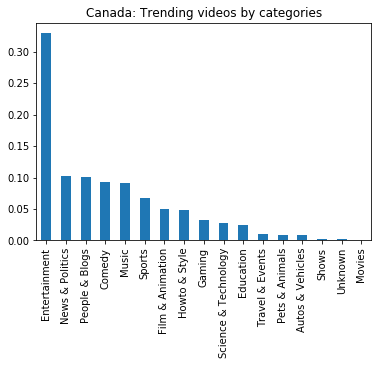

In [11]:
plot_video_count(CANADA, datasets[CANADA], "category_id", "categories", "bar")

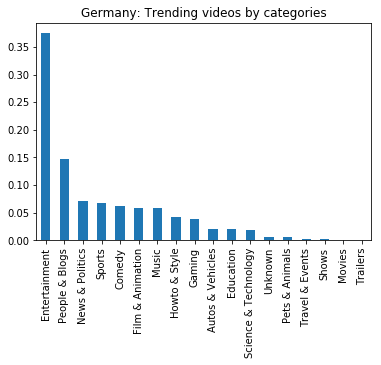

In [12]:
plot_video_count(GERMANY, datasets[GERMANY], "category_id", "categories", "bar")

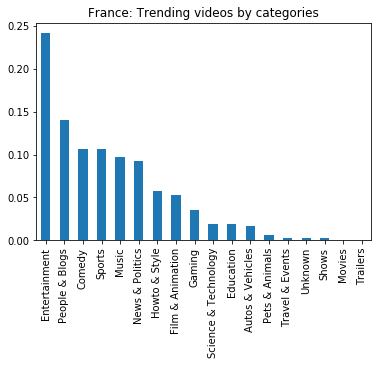

In [13]:
plot_video_count(FRANCE, datasets[FRANCE], "category_id", "categories", "bar")

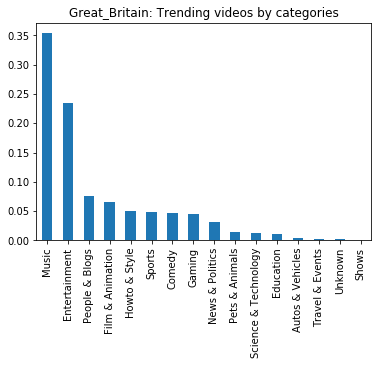

In [14]:
plot_video_count(GREAT_BRITAIN, datasets[GREAT_BRITAIN], "category_id", "categories", "bar")

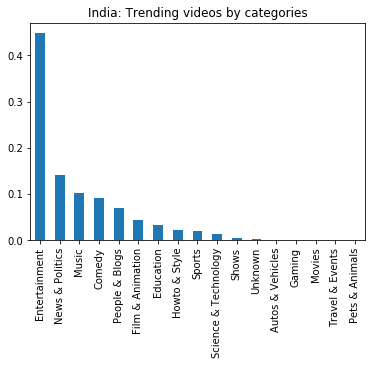

In [15]:
plot_video_count(INDIA, datasets[INDIA], "category_id", "categories", "bar")

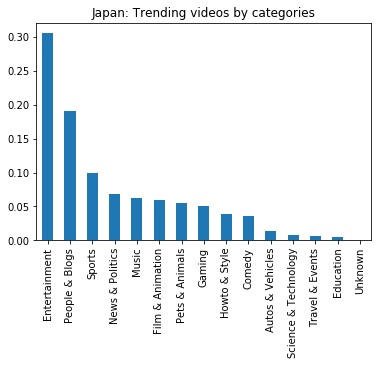

In [16]:
plot_video_count(JAPAN, datasets[JAPAN], "category_id", "categories", "bar")

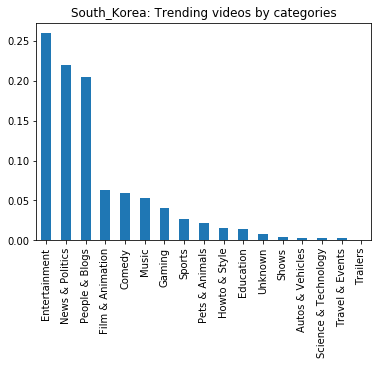

In [17]:
plot_video_count(SOUTH_KOREA, datasets[SOUTH_KOREA], "category_id", "categories", "bar")

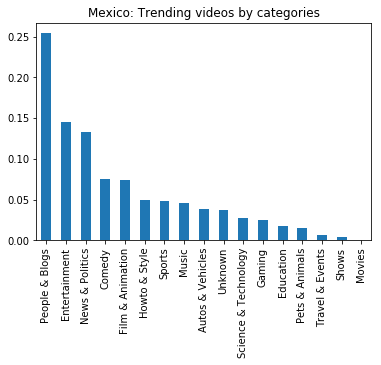

In [18]:
plot_video_count(MEXICO, datasets[MEXICO], "category_id", "categories", "bar")

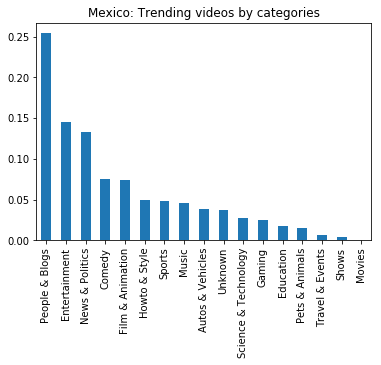

In [19]:
plot_video_count(RUSSIA, datasets[RUSSIA], "category_id", "categories", "bar")

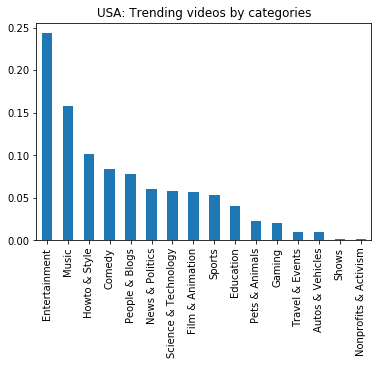

In [20]:
plot_video_count(USA, datasets[USA], "category_id", "categories", "bar")

Conclusion: With a few exceptions, the enterntainment videos are the most common in trending. Music seems to be the top choice in Great Britain and "People & Blogs" seems to be the top choice in Russia, but, even if "Entertainment" is not the first it is still in top 3. In some cases it seems to be a big difference between the first two places, but not everywhere.

# What are the variables that influence the number of views the most?


For this section, we want to see which variables influence the number of views the most and we will also check if we can predict the number of views using the said variables.

In order to see which variables influence the number of views the most, we will create heatmaps for all of the studied countries.

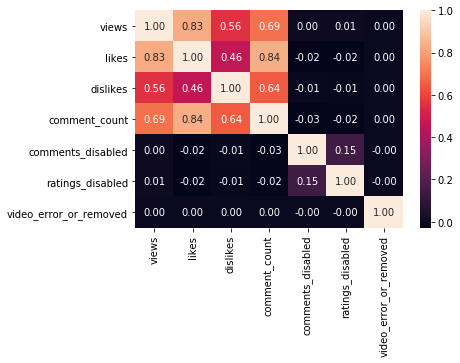

In [21]:
sns.heatmap(canada_dataset.corr(), annot=True, fmt=".2f");

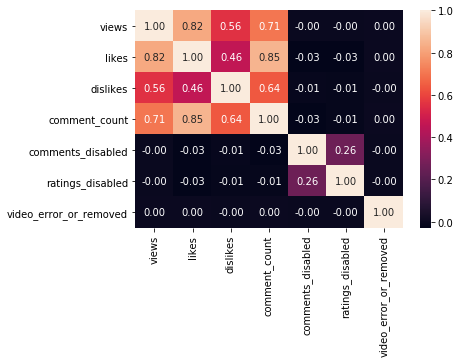

In [22]:
sns.heatmap(germany_dataset.corr(), annot=True, fmt=".2f");

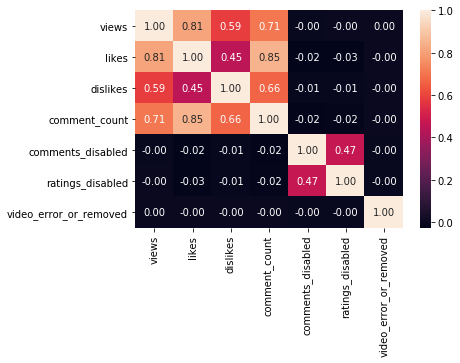

In [23]:
sns.heatmap(france_dataset.corr(), annot=True, fmt=".2f");

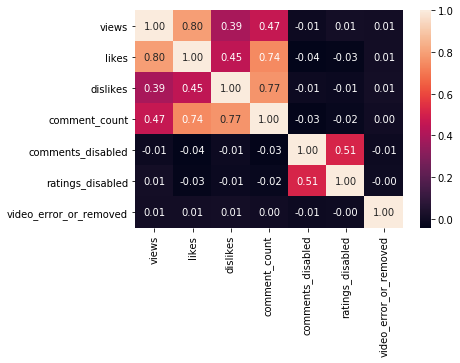

In [24]:
sns.heatmap(great_britain_dataset.corr(), annot=True, fmt=".2f");

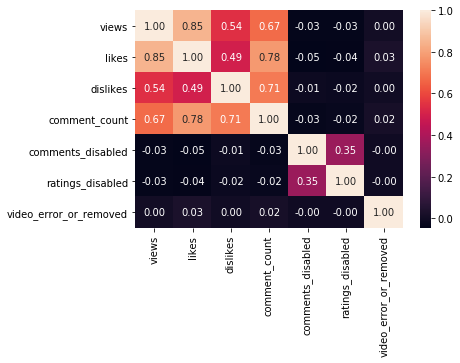

In [25]:
sns.heatmap(india_dataset.corr(), annot=True, fmt=".2f");

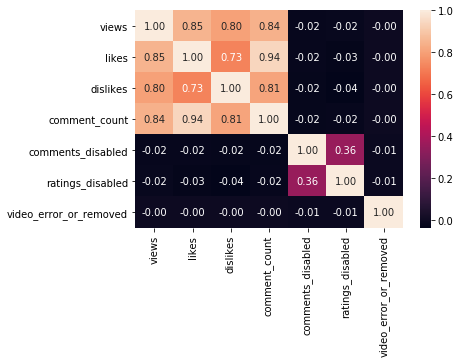

In [26]:
sns.heatmap(japan_dataset.corr(), annot=True, fmt=".2f");

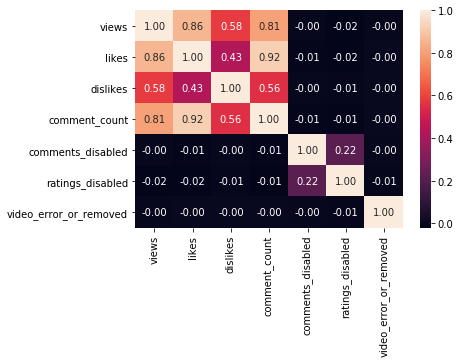

In [27]:
sns.heatmap(south_korea_dataset.corr(), annot=True, fmt=".2f");

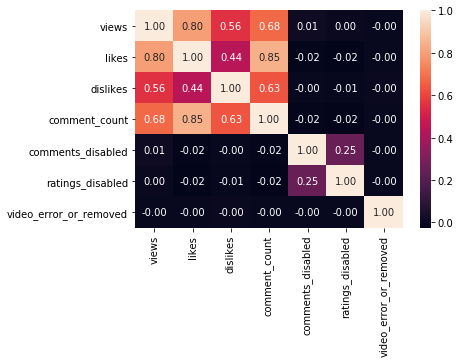

In [28]:
sns.heatmap(mexico_dataset.corr(), annot=True, fmt=".2f");

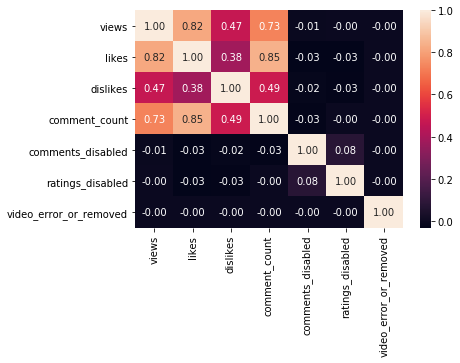

In [29]:
sns.heatmap(russia_dataset.corr(), annot=True, fmt=".2f");

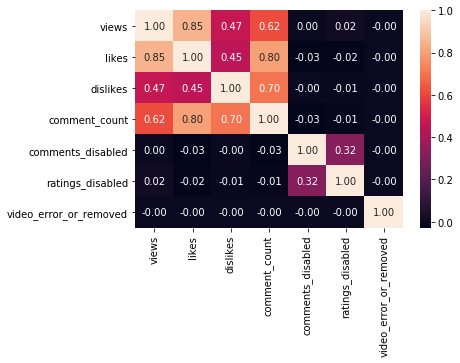

In [30]:
sns.heatmap(usa_dataset.corr(), annot=True, fmt=".2f");

In the function below we are going to run the same Linear Model on the datasets from Japan and from Great Britain.

In [31]:
def train_and_test_model(X, y):
    """ Trains and tests the linear model
        
        Arguments:
        X - the X variable for the linear model
        y- the y variable for the linear model
    """
    # splitting the data between the train and the testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30) 

    # creating the model
    model = LinearRegression(normalize=True)
    
    # fitting the model
    model.fit(X_train, y_train)

    # predicting
    y_test_preds = model.predict(X_test) 

    # showing the score
    print ("The score is {score}".format(score=r2_score(y_test, y_test_preds)))

In [32]:
X = japan_dataset[['likes', 'dislikes', 'comment_count']]
y = japan_dataset['views']

train_and_test_model(X, y)

The score is 0.7445762642204303


In [33]:
X = great_britain_dataset[['likes', 'dislikes', 'comment_count']]
y = great_britain_dataset['views']

train_and_test_model(X, y)

The score is 0.7316667464709288


When running the models we receive varying results. In many cases, we get a strong prediction in both cases.

# Are the same channels trending often?

For this section, we want to see if the same channels appear often in trending. Also, we want to see which channels are most popular in different countries and see if they have anything in common.

In [34]:
def print_frequency_in_trending(dataset):
    """ Prints the chanenels of videos in trending.
        
        Arguments:
        dataset - the dataset that we are analysing
    """
    nr_of_rows = dataset.shape[0]
    most_viewed = dataset["channel_title"].value_counts().sort_values(ascending=False)

    channel_name = []
    videos_trending = []
    frequency = []
    index = 0

    for name, count in most_viewed.items():
        if index == 10:
            break

        freq = count / nr_of_rows

        channel_name.append(name)
        videos_trending.append(count)
        frequency.append(freq)
        index += 1


    tmp = pd.DataFrame({'Channels': channel_name, 'Trending' : videos_trending, 'Frequency' : frequency})
    return tmp
    

In [35]:
print_frequency_in_trending(datasets[CANADA])

,Channels,Frequency,Trending
0,SET India,0.004697,192
1,MSNBC,0.004623,189
2,FBE,0.004599,188
3,The Young Turks,0.004550,186
4,REACT,0.004476,183
5,VikatanTV,0.004452,182
6,CNN,0.004452,182
7,The Late Show with Stephen Colbert,0.004207,172
8,RadaanMedia,0.004109,168
9,ARY Digital,0.004109,168


In [36]:
print_frequency_in_trending(datasets[GERMANY])

,Channels,Frequency,Trending
0,Galileo,0.004897,200
1,Ruhrpottwache,0.004530,185
2,Анатолий Шарий,0.004456,182
3,Auf Streife,0.004407,180
4,Çukur,0.004407,180
5,atv,0.004383,179
6,Promiflash,0.004212,172
7,JP Performance,0.003893,159
8,The Daily Show with Trevor Noah,0.003428,140
9,Söz Dizi,0.003428,140


In [37]:
print_frequency_in_trending(datasets[FRANCE])

,Channels,Frequency,Trending
0,Troom Troom FR,0.004788,195
1,Elhiwar Ettounsi,0.004445,181
2,sam zirah,0.004248,173
3,Lama Faché,0.004199,171
4,Marodi TV Sénégal,0.004150,169
5,VikatanTV,0.004101,167
6,Touche pas à mon poste !,0.003855,157
7,Çukur,0.003708,151
8,Topito,0.003683,150
9,RadaanMedia,0.003610,147


In [38]:
print_frequency_in_trending(datasets[GREAT_BRITAIN])

,Channels,Frequency,Trending
0,The Tonight Show Starring Jimmy Fallon,0.005345,208
1,Jimmy Kimmel Live,0.005319,207
2,TheEllenShow,0.005319,207
3,Saturday Night Live,0.005293,206
4,WWE,0.005268,205
5,The Late Late Show with James Corden,0.005191,202
6,Late Night with Seth Meyers,0.004985,194
7,Breakfast Club Power 105.1 FM,0.004959,193
8,The Late Show with Stephen Colbert,0.004857,189
9,Netflix,0.004805,187


In [39]:
print_frequency_in_trending(datasets[INDIA])

,Channels,Frequency,Trending
0,VikatanTV,0.007603,284
1,etvteluguindia,0.007550,282
2,Flowers Comedy,0.007229,270
3,ETV Plus India,0.006773,253
4,SAB TV,0.006532,244
5,RadaanMedia,0.006506,243
6,SET India,0.006372,238
7,mallemalatv,0.006372,238
8,ETV Jabardasth,0.006265,234
9,Vijay Television,0.006184,231


In [40]:
print_frequency_in_trending(datasets[JAPAN])

,Channels,Frequency,Trending
0,DHCテレビ,0.008235,169
1,釣りよかでしょう。,0.007065,145
2,釣りよか飯,0.005262,108
3,MEGWIN TV,0.004385,90
4,はいじぃ迷作劇場,0.004288,88
5,MAX鈴木 TV,0.004239,87
6,今日ヤバイ奴に会った,0.004093,84
7,水溜りボンド,0.003996,82
8,釣りよかHOUSE,0.003703,76
9,Momo and Tenももと天,0.003703,76


In [41]:
print_frequency_in_trending(datasets[SOUTH_KOREA])

,Channels,Frequency,Trending
0,신의한수,0.006422,222
1,정규재TV,0.006336,219
2,도봉박홍기,0.006307,218
3,보겸 TV,0.005641,195
4,JTBC News,0.005265,182
5,윤창중칼럼세상 TV,0.005149,178
6,철구형 (CHULTUBE),0.004831,167
7,영국남자 Korean Englishman,0.004715,163
8,밴쯔,0.004687,162
9,1등 미디어,0.004658,161


In [42]:
print_frequency_in_trending(datasets[MEXICO])

,Channels,Frequency,Trending
0,Анатолий Шарий,0.004836,197
1,Эхо Москвы,0.004517,184
2,Модные Практики с Паукште Ириной Михайловной,0.004148,169
3,Wylsacom,0.004099,167
4,Россия 24,0.003903,159
5,kamikadzedead,0.003903,159
6,След - новый сезон,0.003805,155
7,Калнина Наталья,0.003805,155
8,PanArmenian TV,0.003731,152
9,Трум Трум,0.003535,144


In [43]:
print_frequency_in_trending(datasets[RUSSIA])

,Channels,Frequency,Trending
0,Анатолий Шарий,0.004836,197
1,Эхо Москвы,0.004517,184
2,Модные Практики с Паукште Ириной Михайловной,0.004148,169
3,Wylsacom,0.004099,167
4,Россия 24,0.003903,159
5,kamikadzedead,0.003903,159
6,След - новый сезон,0.003805,155
7,Калнина Наталья,0.003805,155
8,PanArmenian TV,0.003731,152
9,Трум Трум,0.003535,144


In [44]:
print_frequency_in_trending(datasets[USA])

,Channels,Frequency,Trending
0,ESPN,0.004957,203
1,The Tonight Show Starring Jimmy Fallon,0.004811,197
2,Vox,0.004713,193
3,Netflix,0.004713,193
4,TheEllenShow,0.004713,193
5,The Late Show with Stephen Colbert,0.004567,187
6,Jimmy Kimmel Live,0.004542,186
7,Late Night with Seth Meyers,0.004469,183
8,Screen Junkies,0.004445,182
9,NBA,0.004420,181


In the data displayed above, we can see that, while there are some channels that are have more trending videos than others, they do not have a very high frequency. We have counted the number of days in which a channel has videos in trending, not when individual videos become trending.

# How old are the trending videos?

For this section, we are going to be focusing on two other columns, namely the trending date and the publication time. We want to see how old the videos are in trending. 

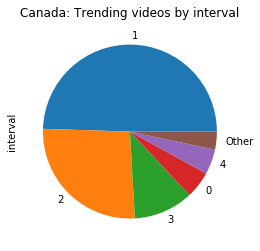

In [45]:
plot_video_count(CANADA,  datasets[CANADA], "interval", "interval", "pie")

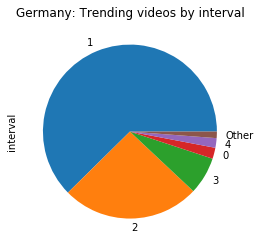

In [46]:
plot_video_count(GERMANY,  datasets[GERMANY], "interval", "interval", "pie")

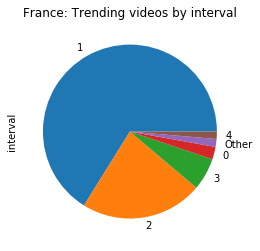

In [47]:
plot_video_count(FRANCE,  datasets[FRANCE], "interval", "interval", "pie")

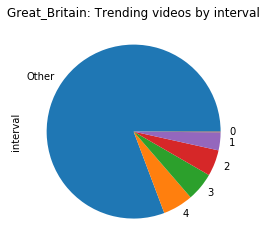

In [48]:
plot_video_count(GREAT_BRITAIN,  datasets[GREAT_BRITAIN], "interval", "interval", "pie")

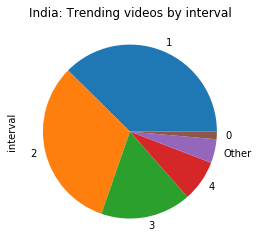

In [49]:
plot_video_count(INDIA,  datasets[INDIA], "interval", "interval", "pie")

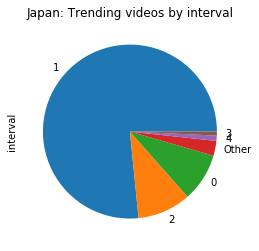

In [50]:
plot_video_count(JAPAN,  datasets[JAPAN], "interval", "interval", "pie")

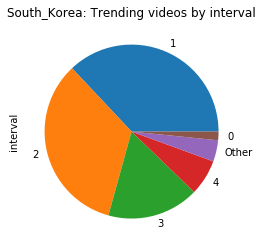

In [51]:
plot_video_count(SOUTH_KOREA,  datasets[SOUTH_KOREA], "interval", "interval", "pie")

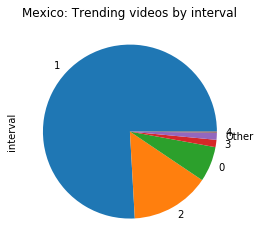

In [52]:
plot_video_count(MEXICO,  datasets[MEXICO], "interval", "interval", "pie")

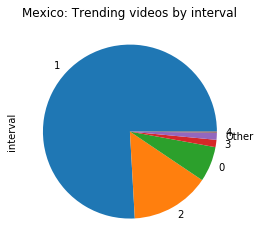

In [53]:
plot_video_count(RUSSIA,  datasets[RUSSIA], "interval", "interval", "pie")

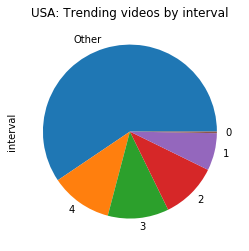

In [54]:
plot_video_count(USA,  datasets[USA], "interval", "interval", "pie")

In [55]:
def print_frequencies(dataset):
    """ Prints how many videos are there, grouped by the number of days since
        they've been posted.
        
        Arguments:
        dataset - the dataset that we will use
    """
    intervals = dataset['trending_date'] - dataset['publish_time']

    frequencies = {}
    for key, val in intervals.items():
        if val.days not in frequencies:
            frequencies[val.days] = 0

        frequencies[val.days] += 1

    for key, val in frequencies.items():
        print (key, val)

In [56]:
print_frequencies(datasets[USA])

0 121
1 2847
2 4303
3 4643
4 4694
5 4584
6 4038
7 3126
8 2184
9 1657
10 1370
11 1198
12 1082
13 938
14 793
15 608
16 471
17 396
18 312
19 222
20 178
21 153
22 135
23 109
24 101
25 98
26 80
27 70
28 43
29 23
30 7
31 4
32 4
33 3
34 3
35 4
36 4
37 2
38 1
39 2
40 2
41 3
42 3
1031 1
44 1
45 1
46 1
47 2
48 4
1032 1
50 3
51 1
59 3
60 3
61 2
62 2
63 1
64 1
65 1
2114 1
2115 1
1094 1
1095 1
1096 1
1097 1
76 1
77 1
78 1
79 1
1116 1
1117 1
1118 1
1119 1
1120 1
2424 1
98 1
99 1
100 1
104 1
3177 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
114 1
2163 1
2164 1
4215 1
135 1
136 1
137 1
138 1
139 1
140 2
141 2
142 1
143 1
146 1
147 1
148 1
1561 1
2202 1
2203 1
1562 1
2416 1
1563 1
2076 1
2077 1
2078 1
2252 1
2251 1
204 1
205 1
206 1
207 1
208 1
209 1
210 1
1030 1
379 1
228 1
1267 1
1268 1
1269 1
1270 1
3113 1
248 1
249 1
250 2
251 1
247 1
256 1
43 1
1285 1
1286 1
1287 1
1288 1
1289 1
1290 1
1291 1
1292 1
1410 2
2334 1
2335 1
288 1
49 4
385 1
2361 1
2362 1
2363 1
2364 1
3398 1
3399 1
3400 1
330 1
331 1
3

In [57]:
print_frequencies(datasets[GREAT_BRITAIN])

0 56
1 1295
2 1891
3 2065
4 2192
5 2236
6 2218
7 2212
8 2161
9 2067
10 1990
11 1887
12 1697
13 1431
14 1137
15 966
16 868
17 810
18 767
19 710
20 674
21 613
22 554
23 523
24 508
25 495
26 476
27 471
28 460
29 423
30 394
31 366
32 346
33 329
34 305
35 286
36 268
37 107
38 6
39 3
40 3
41 3
42 2
1031 1
44 1
45 1
46 1
47 1
48 1
1032 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 2
65 2
66 1
1035 1
68 2
69 3
70 1
1332 1
1036 1
74 1
75 1
76 1
77 1
1037 1
375 1
2526 1
3988 1
188 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 2
2162 1
2163 1
2164 1
2165 1
2166 1
2167 1
2168 1
2169 1
2170 1
2171 1
124 1
125 2
126 2
2425 1
128 2
1153 1
1154 1
1155 1
1156 1
133 1
134 1
193 1
2184 1
2185 1
2186 1
2187 1
2188 1
2189 1
2190 1
2191 1
2192 1
2193 1
1170 1
1171 1
1172 1
1173 1
1174 1
1561 1
196 1
1562 1
1028 1
197 1
3233 1
3234 1
3235 1
3236 1
3237 1
3238 1
369 1
199 1
200 1
182 1
183 1
184 1
1029 1
189 1
190 1
191 1
192 1
1217 1
1218 1
1219 1
1220 1
1221 1
1222 1
1223 1
1224 1
2250 1
225

In most cases, it seems like the most common age for a video that can be found in trending is either 1 or 2 days. However, in the case of USA and Great Britain we decided to perform another analysis, as the most common answer seemed to be "Other". The results of the second analysis are showed above. It seems that the distribution of the age of videos is more even than in the other cases.

# Acknowledgments

In order to create this notebook, I have used [Jupyter Notebook](https://jupyter.org/), [Python](https://www.python.org/), [Pandas](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/).

I don't own the [dataset](https://www.kaggle.com/datasnaek/youtube-new) that I used, just downloaded it from [Kaggle](https://www.kaggle.com/).